# DTSA 5511 - Introduction to Deep Learning Final Project

-----
# Contents

1. Introduction
2. EDA
3. Modeling
4. Results


-------
## 1. Introduction 

In this project I analyze the [Two-class Weather Classification](https://www.cse.cuhk.edu.hk/leojia/projects/weatherclassify/index.htm), this dataset is not part of a kaggle competition but part of a research conducted by a team of four scholars (Cewu Lu, Di Lin, Jiaya Jia, Chi-Keung Tang) which was presented in the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2014. Their research consisted in labeling a outdoor images as either sunny or cloudy using collaborative learning approach. 

Their [paper](https://www.cse.cuhk.edu.hk/leojia/papers/weatherclassify_cvpr14.pdf) gives full details on their approach, the different models they used and metrics for success, etc. For their study they didn't use deep learning but a collection of other algorithms such as SVM, Adaboost, among others. I will be using a neural network to solve this classification task, specifically I will be using tensorflow and keras. 

The dataset is collection of 10 thousand images, divided into two folders 'Cloudy' and 'Sunny', each with exactly 5000 photos. So we have a perfectly balanced dataset.

-------
## 2. Exploratory Data Analysis

Some necessary imports.

In [1]:
import numpy as np # linear algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from PIL import Image

tf.keras.utils.set_random_seed(42)

2023-03-04 13:09:04.851895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's print the names of the folders.

In [3]:
folders = os.listdir("./")
for folder in folders:
    print(folder)

cloudy
.DS_Store
sunny
DTSA5511_FINAL_PROJECT.ipynb
.ipynb_checkpoints


In [4]:
cloudy_path = './cloudy/' 
sunny_path = './sunny/'

cloudy_files =[cloudy_path + file_name for file_name in os.listdir(cloudy_path)]
sunny_files = [sunny_path + file_name for file_name in os.listdir(sunny_path)]

Print the number of images in each folder

In [5]:
print(f"Number of cloudy images: {len(cloudy_files)}")
print(f"Number of sunny images: {len(sunny_files)}")

Number of cloudy images: 5000
Number of sunny images: 5000


Ge the names of the first five images in each folder.

In [6]:
print("CLOUDY:")
print(cloudy_files[:5])
print("\nSUNNY:")
print(sunny_files[:5])

CLOUDY:
['./cloudy/c3248.jpg', './cloudy/c4527.jpg', './cloudy/c2156.jpg', './cloudy/c0999.jpg', './cloudy/c0741.jpg']

SUNNY:
['./sunny/s4933.jpg', './sunny/s3084.jpg', './sunny/s1693.jpg', './sunny/s0599.jpg', './sunny/s1687.jpg']


Each picture in the dataset is exactly 200 by 200 pixels. We must prepare our data for processing. 

In [7]:
def unison_shuffle(a, b):
    """
    Function to shuffle two arrays in sync
    """
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Separate training and test sets, we're going to leave
# 20% of the data for testing. There will 1K cloudy and 1K sunny images. 
train_cloudy, test_cloudy = cloudy_files[:4000], cloudy_files[4000:]
train_sunny, test_sunny = sunny_files[:4000], sunny_files[4000:]

# Concatenate cloudy and sunny for both sets.
train_images = np.concatenate((train_cloudy,train_sunny), axis=0)
test_images = np.concatenate((test_cloudy,test_sunny), axis=0)

# Create a numpy array of labels for the corresponding images
train_labels = np.concatenate((np.zeros((4000,),dtype=int), np.ones((4000,),dtype=int)), axis=0)
test_labels = np.concatenate((np.zeros((1000,),dtype=int), np.ones((1000,),dtype=int)), axis=0)

# Shuffle the datasets
train_images, train_labels = unison_shuffle(train_images, train_labels)
test_images, test_labels = unison_shuffle(test_images, test_labels)

Print first five images in the training set. 

In [8]:
train_images[:5]

array(['./cloudy/c1363.jpg', './cloudy/c0267.jpg', './cloudy/c2485.jpg',
       './cloudy/c2062.jpg', './sunny/s2831.jpg'], dtype='<U18')

Print first five labels in training set.

In [4]:
train_labels[:5]

array([0, 0, 0, 0, 1])

As seen above, at the moment all we have as images are filepaths. But we will change that below. By converting the filepaths to PIL images. 

In [5]:
# Convert the file paths for all images in both training and test sets to
# PIL Image
np.warnings.filterwarnings('ignore')  
train_images = np.array([Image.open(img) for img in train_images])
test_images = np.array([Image.open(img) for img in test_images])

Let's print one image.

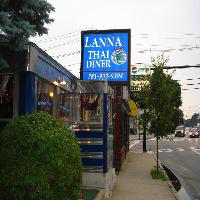

In [37]:
train_images[0]

Now let's convert the images from PIL Images to numpy arrays so that we can use them to train our neural network.

In [6]:
# Now we will convert the images to numpy arrays for processing
train_images_as_arrays = np.array([np.array(img) for img in train_images])
test_images_as_arrays = np.array([np.array(img) for img in test_images])

In [39]:
print("Shape of image: ", train_images_as_arrays[0].shape)
train_images_as_arrays[0]

Shape of image:  (200, 200, 3)


array([[[0.1254902 , 0.17647059, 0.14117647],
        [0.10196078, 0.15294118, 0.11764706],
        [0.09803922, 0.14901961, 0.11372549],
        ...,
        [0.90196078, 0.90196078, 0.93333333],
        [0.89411765, 0.89411765, 0.9254902 ],
        [0.88627451, 0.88627451, 0.91764706]],

       [[0.09803922, 0.14901961, 0.11372549],
        [0.07843137, 0.12156863, 0.09019608],
        [0.06666667, 0.10980392, 0.07843137],
        ...,
        [0.90196078, 0.90196078, 0.93333333],
        [0.89411765, 0.89411765, 0.9254902 ],
        [0.88627451, 0.88627451, 0.91764706]],

       [[0.0627451 , 0.09803922, 0.07843137],
        [0.0745098 , 0.10980392, 0.09019608],
        [0.07843137, 0.11372549, 0.09411765],
        ...,
        [0.90196078, 0.90196078, 0.93333333],
        [0.89411765, 0.89411765, 0.9254902 ],
        [0.88627451, 0.88627451, 0.91764706]],

       ...,

       [[0.05098039, 0.0627451 , 0.01960784],
        [0.05882353, 0.07058824, 0.02745098],
        [0.05882353, 0

As we see in the code above, after converting the images to numpy arrays we are left with a matrix of the shape (200, 200, 3). The third dimension corresponds to the property that each image has three channels Red, Green and Blue. 

In [8]:
class_names = ["Cloudy", "Sunny"]

The following shows there are 8,000 images in the training set, with each image represented as 200 x 200 pixels:

In [9]:
train_images_as_arrays.shape

(8000, 200, 200, 3)

Likewise, there are 8,000 labels in the training set. 

In [10]:
len(train_labels)

8000

Each label is an integer, either 0 or 1. For Cloudy and Sunny Respectively. 

In [11]:
train_labels

array([0, 0, 0, ..., 0, 1, 1])

There are 2,000 images in the test set, with each image represented as 200 x 200 pixels:

In [12]:
test_images_as_arrays.shape

(2000, 200, 200, 3)

Likewise the test set contains 2,000 images labels:

In [13]:
len(test_labels)

2000

**Preprocess the data**

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255

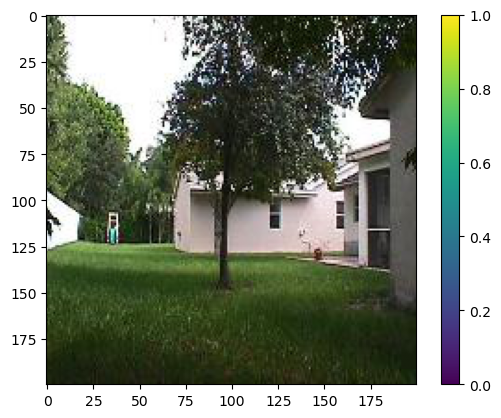

In [41]:
plt.figure()
plt.imshow(train_images_as_arrays[11])
plt.colorbar()
plt.grid(False)
plt.show()

Here I scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.

In [15]:
train_images_as_arrays = train_images_as_arrays / 255.0

test_images_as_arrays = test_images_as_arrays / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

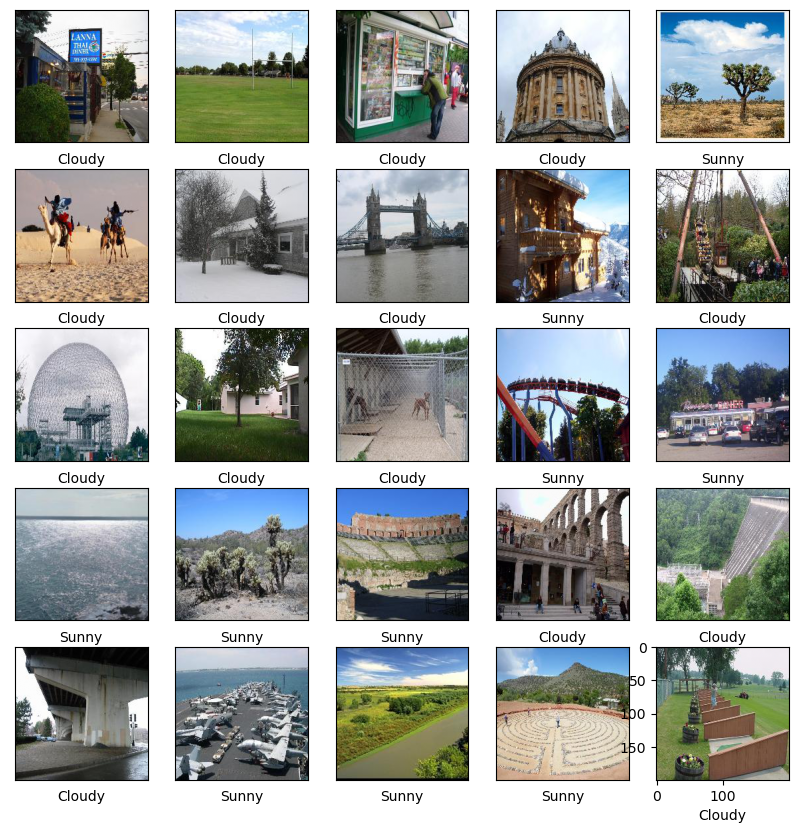

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.subplot(5,5,1+i)
    plt.xlabel(class_names[train_labels[i]])
    plt.imshow(train_images_as_arrays[i])
plt.show()

-------
## 3. Modeling

**Building the model**

Building the neural network requires configuring the layers of the model, then compiling the model.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a three-dimensional array (of 200 by 200 by 3 pixels) to a one-dimensional array (of 200 * 200 * = 120,000 pixels). This essentially flattens the array of values. This layer has no parameters to learn; it only reformats the data.

Before the model is ready for training. Below I setup the loss function, optimizer and metrics for compiling. 

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Feed The model**

In [19]:
model.fit(train_images_as_arrays, train_labels, epochs=10)

Epoch 1/10
250/250 [==============================] - 66s 261ms/step - loss: 7.3581 - accuracy: 0.7001
Epoch 2/10
250/250 [==============================] - 47s 187ms/step - loss: 4.8815 - accuracy: 0.7401
Epoch 3/10
250/250 [==============================] - 47s 188ms/step - loss: 3.7948 - accuracy: 0.7574
Epoch 4/10
250/250 [==============================] - 46s 184ms/step - loss: 3.0094 - accuracy: 0.7671
Epoch 5/10
250/250 [==============================] - 47s 186ms/step - loss: 1.5135 - accuracy: 0.7994
Epoch 6/10
250/250 [==============================] - 46s 185ms/step - loss: 1.0468 - accuracy: 0.8084
Epoch 7/10
250/250 [==============================] - 47s 187ms/step - loss: 0.7130 - accuracy: 0.8404
Epoch 8/10
250/250 [==============================] - 46s 185ms/step - loss: 0.7668 - accuracy: 0.8194
Epoch 9/10
250/250 [==============================] - 47s 188ms/step - loss: 0.5047 - accuracy: 0.8481
Epoch 10/10
250/250 [==============================] - 46s 185ms/step - l

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.8571 (or 86%) on the training data.

----- 
## 4. Results

**Evaluating Accuracy**

Next, compare how the model performs on the test dataset:

In [20]:
test_loss, test_acc = model.evaluate(test_images_as_arrays,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 2s - loss: 0.6142 - accuracy: 0.8115 - 2s/epoch - 26ms/step

Test accuracy: 0.8115000128746033


It turns out that the accuracy on the test set was almost exactly the same as the accuracy on the training set which is great as it shows that the model didn't suffer from overfitting. 

**Making Predictions**

With the model already trained, we can use it to make predictions about images individually. Attaching a softmax layer to convert the model's linear outputs—logits—to probabilities, which should be easier to interpret.

In [21]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [22]:
predictions = probability_model.predict(test_images_as_arrays)

63/63 [==============================] - 1s 20ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [23]:
predictions[0]

array([2.9484747e-04, 9.9970520e-01, 5.5766196e-34, 9.5897300e-35,
       8.2960161e-29, 1.2884307e-29, 3.2090569e-36, 1.1080780e-35,
       7.9351372e-20, 1.8716790e-26], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to either of the two classes, cloudy or sunny. We can see which label had the highest confidence value by: 

In [24]:
np.argmax(predictions[0])


1

So, the model was the most confident that this image was a sunny one. Examining the test label shows that this classification is correct:

In [25]:
test_labels[0]

1

In [26]:
def show_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label != true_label:
        color = 'red'
    else:
        color = 'green'
        

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def show_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.yticks([])
    plt.xticks(range(2))
    true_label = true_label[i]
    thisplot = plt.bar(range(10), predictions_array, color="#FFFFFF")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[true_label].set_color('blue')
    thisplot[predicted_label].set_color('red')

**Verifying Predictions**
With the model trained, we can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

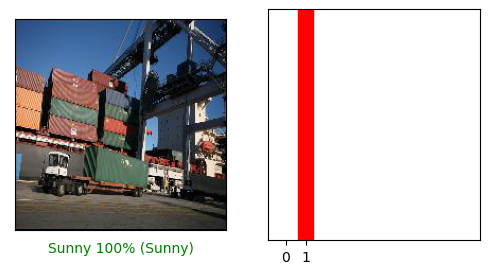

In [27]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
show_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
show_value_array(i, predictions[i],  test_labels)
plt.show()

Now let's take a look at another one, say the 12th prediction. We see below that it is an incorrect prediction. Where our model predicted with 65% accuracy that it was sunny and 35% that it was cloudy, since sunny had greater weight, it labeled it as sunny, however in the test_labels array the 12th label is 0 for cloudy. 

This is an example of an incorrect classification. 

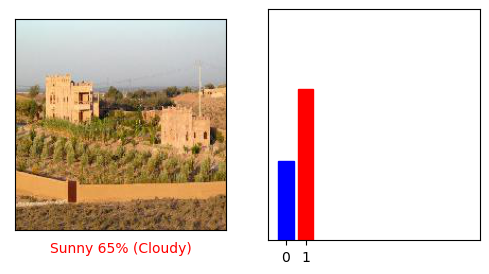

In [28]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
show_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
show_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions.

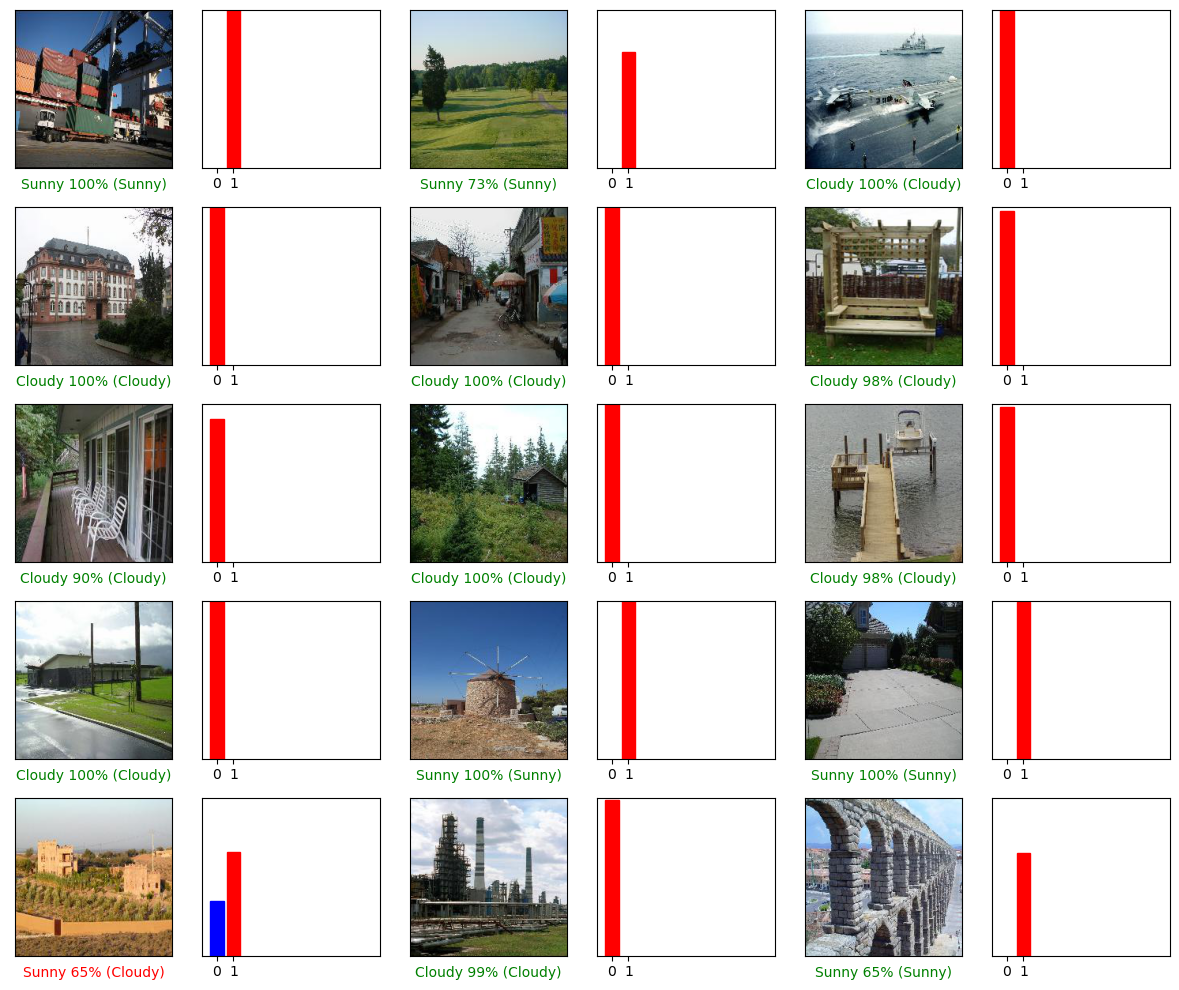

In [29]:
plt.figure(figsize=(2*2*3, 2*5))

for i in range(15):
    plt.subplot(5, 2*3, 2*i+1)
    show_image(i, predictions[i], test_labels, test_images)
    plt.subplot(5, 2*3, 2*i+2)
    show_value_array(i, predictions[i], test_labels)
    
plt.tight_layout()
plt.show()

**Conclusion** 

At this point we have a trained model that performs with approximately 80% accuracy. We could use new images use it as input for the model and make predictions on new data. 

Keras provides a high-level interface that makes it very friendly to take advantage of deep learning. One of the downsides of deep learning is that it requires massive amounts of data to be effective. 

Thanks for taking the time to review this assignment. 